Welcome to module 2.2. In this module, we will use a popular Python module `scikit-learn` to build a sentiment classifier with Naive Bayes! We will introduce the concept of feature as numerical representation of the input data. We will experiment with different types of features to investiage their impact on training. 
At the end of the module, you should be able to:

* understand features and how to extract them from input data
* experiment with an off-the-shelf Naive Bayes model
* be familar with the pipeline for bulding a machine learning model incluidng data cleaning, feature extraction, and model evaluation.


Let's first refresh your memory on the Naive Bayes model. 

### ❓ Pre-module quiz

Say that we have two events: Fire and Smoke. $P(Fire)$ is the probability of a fire (or in other words, how often a fire occurs), $P(Smoke)$ is the probability of seeing smoke (how often we see smoke). We want to know $P(Fire|Smoke)$, that is, how often fire occurs when we see smoke. Suppose we know the following:

$P(Fire)=0.01$

$P(Smoke)=0.1$

$P(Smoke|Fire)=0.9$ (ie. 90\% of the fire makes smoke)


Can you work out $P(Fire|Smoke)$?

A. 0.1

B. 0.09

C. 0.01

D. 0.9




<hr>    <!-- please remember this! -->
<details>
  <summary>Click <b>here</b> to see the answer.</summary>
  <p>\begin{equation*}P(Fire|Smoke) =  \frac{P(Fire)*P(Smoke|Fire)}{P(Smoke)} \end{equation*} </p>
<p>\begin{equation*}=\frac{0.01 * 0.9}{ 0.1} \end{equation*}</p>
<p>\begin{equation*}=0.09\end{equation*}</p>

</details> 



# Sentiment Analysis Task Introduction

Our task of focus today is a popular NLP classification task: sentiment analysis. What exactly is sentiment? Sentiment is an opinion or emotion (usually positive or negative) that is reflected in a sequence of words. And analysis? Well, this is the process of looking at data and making inferences about the sentiment; in our case, we will use machine learning to learn and predict whether a movie review is positive or negative.

We will replicate some of the experiments from the paper: [Thumbs up? Sentiment Classification using Machine Learning Techniques](https://www.aclweb.org/anthology/W02-1011.pdf). We will extract a number of features including unigrams, bigrams etc., and train Naive Bayes models on these features. (Notice that we use the second release of the data which is preprocessed and cleaned rather than the original data in the paper. Therefore, the results are not directly comparable. )

## Preparing data

The data for this tutorial is stored in the `./data` folder. The two subdirectories `./data/pos` and `./data/neg` contain samples of IMDb positive and negative movie reviews. Each line of a review text file is a tokenized sentences. 

As usual, we download the files for the notebook from Github. If you're running this notebook locally or on Binder, you may skip this cell.

In [ ]:
!wget https://github.com/cambridgeltl/python4cl/raw/master/module_2/module_2.2/data.zip
!unzip -n -q data.zip

--2021-01-29 10:20:10--  https://github.com/cambridgeltl/python4cl/raw/master/module_2/module_2.2/data.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cambridgeltl/python4cl/master/module_2/module_2.2/data.zip [following]
--2021-01-29 10:20:10--  https://raw.githubusercontent.com/cambridgeltl/python4cl/master/module_2/module_2.2/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4848090 (4.6M) [application/zip]
Saving to: ‘data.zip.2’

data.zip.2          100%[===================>]   4.62M  --.-KB/s    in 0.09s   

2021-01-29 10:20:11 (49.1 MB/s) - ‘data.zip.2’ saved [4848090/4848090]



We can load an individual text file by opening it, reading in the ASCII text, and closing the file. For example, we can load the first negative review file “cv000_29416.txt” as follows:


In [ ]:

# load one file
filename = 'data/neg/cv000_29416.txt'
# open the file as read only
file = open(filename, 'r')
# read all text
text = file.read()
print (text)
# close the file
file.close()


plot : two teen couples go to a church party , drink and then drive . 
they get into an accident . 
one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . 
what's the deal ? 
watch the movie and " sorta " find out . . . 
critique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . 
which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn't snag this one correctly . 
they seem to have taken this pretty neat concept , but executed it terribly . 
so what are the problems with the movie ? 
well , its main problem is that it's simply too jumbled . 
it starts off " normal " but then downshifts into this " fantasy " world in which you , as an audience member , have no id

This loads the document as ASCII and preserves any white space, like new lines.

We can turn this into a function called `load_doc()` that takes a filename of the document to load and returns the text.


In [ ]:
# load doc into memory
def load_doc(filename):
    """
    Parameters
    ----------
    filename: the filename to extract text

    Return
    ------
    text in strings
    """
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text


We can process each directory in turn by first getting a list of files in the directory using the `listdir()` function from the `os` module, then loading each file in turn.

For example, we can load each document in the negative directory using the `load_doc()` function to do the actual loading. Below, we define a `process_docs()` function to load all documents in a folder. 

In [ ]:
from os import listdir 
# load all docs in a directory
def process_docs(directory):
    """
    Parameters
    ----------
    directory: a directory containing positive/negative samples from the Thumbs
    Up! dataset.

    Return
    ------
    A list of of documents, where each document is string text
    """
    # walk through all files in the folder
    docs=[] # a list of review texts
    files=listdir(directory)
    files=sorted(files)
    for filename in files:
        # skip files that do not have the right extension
        if not filename.endswith(".txt"):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load document
        doc = load_doc(path)
        print('Loaded %s' % filename)
        docs.append(doc)
    return docs
 
# specify directory to load
directory = 'data/neg'
docs=process_docs(directory)

Loaded cv000_29416.txt
Loaded cv001_19502.txt
Loaded cv002_17424.txt
Loaded cv003_12683.txt
Loaded cv004_12641.txt
Loaded cv005_29357.txt
Loaded cv006_17022.txt
Loaded cv007_4992.txt
Loaded cv008_29326.txt
Loaded cv009_29417.txt
Loaded cv010_29063.txt
Loaded cv011_13044.txt
Loaded cv012_29411.txt
Loaded cv013_10494.txt
Loaded cv014_15600.txt
Loaded cv015_29356.txt
Loaded cv016_4348.txt
Loaded cv017_23487.txt
Loaded cv018_21672.txt
Loaded cv019_16117.txt
Loaded cv020_9234.txt
Loaded cv021_17313.txt
Loaded cv022_14227.txt
Loaded cv023_13847.txt
Loaded cv024_7033.txt
Loaded cv025_29825.txt
Loaded cv026_29229.txt
Loaded cv027_26270.txt
Loaded cv028_26964.txt
Loaded cv029_19943.txt
Loaded cv030_22893.txt
Loaded cv031_19540.txt
Loaded cv032_23718.txt
Loaded cv033_25680.txt
Loaded cv034_29446.txt
Loaded cv035_3343.txt
Loaded cv036_18385.txt
Loaded cv037_19798.txt
Loaded cv038_9781.txt
Loaded cv039_5963.txt
Loaded cv040_8829.txt
Loaded cv041_22364.txt
Loaded cv042_11927.txt
Loaded cv043_16808.

**<h3>💻 Try it yourself!</h3>**

Use the predefined `process_docs()` function to read in negative texts and positive reviews. How many reviews are there for each class? 

You can write your code below:


<hr>    <!-- please remember this! -->
<details>
  <summary>Click <b>here</b> to see the answer.</summary>
    <p>1000 positive and 1000 negative reviews</p>

<!--   <p>\begin{equation*}P(Fire|Smoke) =  \frac{P(Fire)*P(Smoke|Fire)}{P(Smoke)} \end{equation*} </p>
<p>\begin{equation*}=\frac{0.01 * 0.9}{ 0.1} \end{equation*}</p>
<p>\begin{equation*}=0.09\end{equation*}</p> -->

</details> 



# Feature Extraction


So far we have obtained the text of each document. If we follow the previous module's definition on Naive Bayes, we could take bag of word represention for each document, and compute the likelihood $P(d \mid c)$ as:

$P(d \mid c) = P(w_1, \dots , w_n \mid c) $

This is however only one way to represent the document. We could for example select some of the words (eg. more informative words) or use bigrams instead of unigram words, or combine unigrams and bigrams to represent the document. We could even add information such as document length, date of creation into the representation. All these measurable properties that we can use to represent the input data are referred to as $features$. We can replace $w_1, w_2, \dots, w_n$ with the more general form: $f_1,f_2,\dots,f_n$ to indicate individual features. The following is the new formulation of the likelihood. 

$P(d \mid c) = P(f_1, \dots , f_n \mid c) $

Practically, we can group a document's feature values into a list: [f1,f2..fn]. This will be a numerical representation of the document that can be fed directly into a model. We call this list of numbers as a feature vector. 

Below, We delve deeper into the concept of features and feature vectors. 


## Feature vector?

The feature vector has a fixed length corresponding to the number of features. Each position of the list represents the value of a feature. For example, to represent unigrams in a document, we can create a vector with the same length of the vocabulary, and the value in each position of the list stores the frequency or presence of a specific word. 


As an example, suppose we have eight words (apple,banana,red,dog,is,the,and,yellow) in the vocabulary which are represented as eight features. We also have two documents as in below:

document 1: "the apple is red and the banana is yellow"
document 2: "the red dog"

To produce a feature vector to represent unigram presence in a document, we can write '1' in a position where the correspoding word is present in the document, and we will write '0' to indicate the word is not present. Below is a table view of the vectors. 


document no.  |  apple | banana | red | dog | is | the | and | yellow |
------|------|------|------|------|------|------|------|------|
document 1 |1|1|1|0|1|1|1|1|
document 2 |0|0|1|1|0|1|0|0|


The feature vector for document 1 becomes `[1,1,1,0,1,1,1,1]`

To produce a feature vector that represent frequency of each unigram in a document, we can count the number of occurence of each unigram word and write down the number in the corresponding position. 

document no. | apple | banana | red | dog | is | the | and | yellow |
------|------|------|------|------|------|------|------|------|
document 1 |1|1|1|0|2|2|1|1|
document 2 |0|0|1|1|0|1|0|0|


Now the feature vector for document 1 becomes `[1,1,1,0,2,2,1,1]`

When the data consists of more than one document as in our example, we will have multiple feature vectors as representations of our data. We can stack the vectors into a list of vectors. This is often referred to as matrix. 
In our example, we have a 2*8 matrix where 2 is the number of documents, and 8 is the number of features

The presence feature matrix for our toy data is: `[[1,1,1,0,1,1,1,1],[0,0,1,1,0,1,0,0]]`


### ❓ Quiz  


Following the examples, please write below both the unigram presence and unigram frequency feature vectors for the document text 'the red dog and the red apple'




<hr>    <!-- please remember this! -->
<details>
  <summary>Click <b>here</b> to see the answer.</summary>
    <p>Unigram presence feature vector: [1,0,1,1,0,1,1,0]</p>
    <p>Unigram frequency feature vector: [1,0,2,1,0,2,1,0]</p>


</details> 



### ❓ Quiz  

What is the matrix consisting of the unigram presence vectors of the following documents:

document1: 'the apple is red and the banana is yellow'

document2: 'the red dog and the red apple'


<hr>    <!-- please remember this! -->
<details>
  <summary>Click <b>here</b> to see the answer.</summary>
    <p>The matrix is: [[1,1,1,0,1,1,1,1], [1,0,1,1,0,1,1,0]] </p>


</details> 



## Numpy arrays

The feature vectors are commonly represented as `numpy` arrays in Python. Let's spend some time to understand what `numpy` is. 

A `numpy` array is just like a `list` but with smaller memory and faster access. 

Below, we introduce several ways to create a numpy array

In [ ]:
import numpy as np
# Create a numpy array of zeros with size 2
vector1=np.zeros(2)
# create a numpy array from a list [1,2,3]
vector2=np.array([1,2,3])
# create an empty array of size 3 with arbitary data
vector3=np.empty(3)
print ('vector1',vector1)
print ('vector2',vector2)
print ('vector3',vector3)

vector1 [0. 0.]
vector2 [1 2 3]
vector3 [0.75 0.75 0.  ]


We can also concatenate two numpy arrays of the same size

In [ ]:
np.concatenate((vector2,vector3))

array([1.  , 2.  , 3.  , 0.75, 0.75, 0.  ])

So far, we have created numpy arrays of one dimension (i.e. an array of numbers). Let's try creating a 2-D array (also called a matrix, or a nested array). We can pass dimension size (also called axes) as (a,b) where a is the number of rows in the matrix, and b specifies the number of columns. 

In [ ]:
matrix1=np.zeros((3,3)) 
# this is a matrix of zeros that has 3 vectors, and within each vector there are 4 items. 
print ('matrix1',matrix1)
# a matrix from nested list
matrix2=np.array([[1,2,3],[2,3,4]])
print ('matrix2',matrix2)
# an empty matrix usually used as initialisation. It will print as an empty list
matrix3=np.empty((0,4))
print ('matrix3',matrix3)
#To check the axes of an array, you can retrieve the shape attributes as tuple of dimension sizes like this:
print (matrix2.shape) 


matrix1 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
matrix2 [[1 2 3]
 [2 3 4]]
matrix3 []
(2, 3)


Numpy arrays are mutable. Therefore, we can change values in the vector. For example:

In [ ]:
vector2[0]=0 # change the first item in vector3 to 0
print (vector2)
matrix2[0][2]=0 # change the third item of the first vector to 0
print (matrix2)
matrix2[0]=vector2 # change the first vector in matrix2 to vector3
print (matrix2)


[0 2 3]
[[1 2 0]
 [2 3 4]]
[[0 2 3]
 [2 3 4]]


We can also slice a numpy array with an index array. 

In [ ]:
#Let's select the values at index 1,2 of vector2
vector2[[1,2]]

array([2, 3])

## Extracting unigrams

Now let's extract unigram features from our data. First, let’s load one document and look at the raw tokens split by white space. We will use the `load_doc()` function developed in the previous section. We can use the `split()` function to split the loaded document into unigram tokens separated by white space.

In [ ]:
# load the document
filename = 'data/neg/cv000_29416.txt'
text = load_doc(filename)
# split into tokens by white space
tokens = text.split()
print(tokens)

['plot', ':', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party', ',', 'drink', 'and', 'then', 'drive', '.', 'they', 'get', 'into', 'an', 'accident', '.', 'one', 'of', 'the', 'guys', 'dies', ',', 'but', 'his', 'girlfriend', 'continues', 'to', 'see', 'him', 'in', 'her', 'life', ',', 'and', 'has', 'nightmares', '.', "what's", 'the', 'deal', '?', 'watch', 'the', 'movie', 'and', '"', 'sorta', '"', 'find', 'out', '.', '.', '.', 'critique', ':', 'a', 'mind-fuck', 'movie', 'for', 'the', 'teen', 'generation', 'that', 'touches', 'on', 'a', 'very', 'cool', 'idea', ',', 'but', 'presents', 'it', 'in', 'a', 'very', 'bad', 'package', '.', 'which', 'is', 'what', 'makes', 'this', 'review', 'an', 'even', 'harder', 'one', 'to', 'write', ',', 'since', 'i', 'generally', 'applaud', 'films', 'which', 'attempt', 'to', 'break', 'the', 'mold', ',', 'mess', 'with', 'your', 'head', 'and', 'such', '(', 'lost', 'highway', '&', 'memento', ')', ',', 'but', 'there', 'are', 'good', 'and', 'bad', 'ways', 'of'

To keep track of the frequency and presence for each token in the document, we will use the `Counter` dictionary from `collections` module. Let's write a function `tokens_to_dict()` that turns a list of unigram tokens into a counter dictionary. 

In [ ]:
from collections import Counter
def tokens_to_dict(tokens):
    """
    Parameters
    ----------
    tokens: a list of tokens in a document

    Return
    ------
    A counter dictionary that records the number of occurrence for each token in a document
    """
    token2count=Counter()
    for token in tokens:
        token2count[token]+=1
    return token2count

tokens_dict=tokens_to_dict(tokens)
print (tokens_dict)

Counter({',': 44, 'the': 38, '.': 34, 'it': 21, 'and': 20, 'to': 16, 'of': 16, 'a': 14, 'that': 13, 'are': 13, 'is': 12, 'but': 10, '"': 10, 'this': 10, 'there': 10, '(': 9, ')': 9, 'in': 8, 'i': 7, '-': 7, '?': 6, 'movie': 6, 'all': 6, 'they': 5, 'into': 5, 'with': 5, 'pretty': 5, 'film': 5, 'make': 5, 'teen': 4, 'her': 4, 'for': 4, 'on': 4, 'which': 4, 'just': 4, 'its': 4, "it's": 4, 'from': 4, 'most': 4, 'over': 4, 'we': 4, ':': 3, 'then': 3, 'get': 3, 'an': 3, 'one': 3, 'has': 3, 'out': 3, 'even': 3, 'so': 3, 'you': 3, 'who': 3, 'like': 3, 'not': 3, '!': 3, 'two': 2, 'go': 2, 'see': 2, "what's": 2, 'mind-fuck': 2, 'very': 2, 'cool': 2, 'idea': 2, 'bad': 2, 'what': 2, 'since': 2, 'films': 2, 'your': 2, 'lost': 2, 'highway': 2, 'memento': 2, 'good': 2, "didn't": 2, 'have': 2, 'problem': 2, 'simply': 2, 'world': 2, 'audience': 2, 'going': 2, 'coming': 2, 'dead': 2, 'others': 2, 'look': 2, 'scenes': 2, 'things': 2, 'now': 2, "don't": 2, 'same': 2, 'again': 2, 'up': 2, 'after': 2, 'bigg

We can put all above preprocessing steps into a function `clean_doc_unigrams()`. This function will preprocess the data and extract unigram tokens from the document. We then test it on another review, this time a positive review.


In [ ]:
# turn a doc into clean tokens
def clean_doc_unigrams(doc):
    """
    Parameters
    ----------
    doc: text from a document

    Return
    ------
    A counter dictionary of tokens
    """
    # split into tokens by white space
    tokens = doc.split()
    tokens_dict=tokens_to_dict(tokens)
    return tokens_dict
 
# load the document
filename = 'data/pos/cv000_29590.txt'
text = load_doc(filename)
tokens_dict = clean_doc_unigrams(text)
print(tokens_dict)

Counter({'the': 46, ',': 43, '.': 23, 'and': 20, '(': 18, ')': 18, 'in': 18, 'a': 15, 'to': 15, 'of': 14, 'from': 8, 'but': 7, 'is': 7, 'it': 6, '"': 6, 'comic': 5, "don't": 5, 'film': 5, 'about': 4, 'like': 4, 'who': 4, 'with': 4, 'say': 4, 'you': 4, 'this': 4, "it's": 4, 'i': 4, 'had': 3, 'or': 3, 'been': 3, 'book': 3, 'for': 3, 'moore': 3, 'campbell': 3, 'ripper': 3, 'be': 3, 'that': 3, "hell's": 3, 'me': 3, ':': 3, 'than': 3, '?': 3, 'he': 3, 'an': 3, 'so': 3, 'even': 3, 'at': 3, 'all': 3, 'have': 2, 'world': 2, 'never': 2, 'really': 2, 'hell': 2, 'whole': 2, 'called': 2, 'jack': 2, 'starting': 2, 'little': 2, 'if': 2, 'more': 2, 'other': 2, 'because': 2, 'get': 2, 'hughes': 2, 'direct': 2, 'seems': 2, 'as': 2, 'ghetto': 2, 'whitechapel': 2, 'end': 2, 'place': 2, 'has': 2, 'when': 2, 'first': 2, 'turns': 2, 'peter': 2, 'not': 2, 'enough': 2, 'abberline': 2, 'depp': 2, 'graham': 2, 'into': 2, 'here': 2, 'both': 2, 'identity': 2, 'good': 2, '-': 2, 'make': 2, 'see': 2, '2': 2, "wasn'

Finally, we can integrate the above preprocessing `clean_doc_unigrams()` into the data processing pipeline for all the files in a directory. We do so by the function `process_docs_unigram()`. 


In [ ]:
# load all docs in a directory
def process_docs_unigrams(directory):
    """
    Parameters
    ----------
    directory: a directory containing positive/negative samples from the Thumbs
    Up! dataset.

    Return
    ------
    A list of unigram token counter dictionary where each token dictionary records the frequency of each token that occur in a document. 
    """
    # walk through all files in the folder
    print (directory)
    tokens_all=[]
    files=listdir(directory)
    for filename in sorted(files):
        # skip files that do not have the right extension
        if not filename.endswith(".txt"):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load document
        text=load_doc(path)
        # clean documents
        tokens_dict = clean_doc_unigrams(text)
        tokens_all.append(tokens_dict)
    return tokens_all


# unigrams for all the negative files
unigrams_neg=process_docs_unigrams('./data/neg')
# unigrams for all the positive files
unigrams_posi=process_docs_unigrams('./data/pos')
# all unigrams
unigrams_all=unigrams_posi+unigrams_neg


./data/neg
./data/pos


## Turn text to feature vectors

Now that we have the count of each present unigrams for each document, we can convert these unigram counts into feature vectors. But before that, we first need to collect all the features to establish the size of the feature vector. Here, the features are unigram words in the vocabulary. To do this, we define a function `collect_vocab()` to collect all the unique words in the vocabulary from `unigrams_all`, the list of token dictionary from all the documents. 

In [ ]:
from collections import Counter
def collect_vocab(tokens_all,min_count=0):
    """
    Parameters
    ----------
    tokens_all: a list of token dictionaries where each token dictionary is extracted from a document. 
    min_count: the minimum count of tokens that are selected. The default is 0, and therefore all tokens are included. 

    Return
    ------
    a set of unique tokens in the vocabulary of tokens_all
    """
    
    vocab=Counter() #Here, we create a `set()` to store all the unique words.
    for token_dict in tokens_all: # iterate through token dictionary for each document
        for token in token_dict:
            # add a word in the vocab set. If a word already exists in vocab, it will not be added twice.
            vocab[token]+=token_dict[token]
    vocab=set([token for token in vocab if vocab[token]>min_count])
    return vocab


unigram_vocab=collect_vocab(unigrams_all)
# Let's check how many words we have in the vocab
print (len(unigram_vocab))

50920


Now let's create the mapping between vocabulary and feature vecor position index from `unigram_vocab`. We can define a function `create_vocab_feature_mappings()` to do this:

In [ ]:
def create_vocab_feature_mappings(vocab):
    """
    Parameters
    ----------
    vocab: a set of unique features in the vocabulary

    Return
    ------
    vocab2index: a mapping dictionary with feature as key and position index as value
    index2vocab: a mapping dicitoanry with position index as key and feature as value
    """
    vocab2index={}
    index2vocab={}
    for i,w in enumerate(vocab): # iterate through the words in the vocabulary
        vocab2index[w]=i
        index2vocab[i]=w
    return vocab2index,index2vocab

unigram2index,index2unigram=create_vocab_feature_mappings(unigram_vocab)

Now, we can use `unigram2index` mapping dictionary to turn each document's token dictionary representation into a unigram feature vector. Remember, we can either represent in each vector item the freqency of the words, or use 1 or 0 to represent whether a word occurs or not. 
Let's design two functions `create_feature_presence()` and `create_feature_frequency()`  to turn the token dictionary for each document into these two types of features. 

To create the `create_feature_presence()`, we can do the following:

In [ ]:
import numpy as np
def create_feature_presence(token_dict,vocab2index):
    """
    Parameters
    ----------
    token_dict: a token counter dictionary for a document
    vocab2index: a mapping dictionary with feature as key and feature index as value

    Return
    ------
    a feature vector for the document
    """
    # create a numpy array with size of the vocabulary size
    vector=np.zeros(len(vocab2index))
    for w in token_dict:
        if w in vocab2index:
          index=vocab2index[w]
          vector[index]=1
    return vector


**<h3>💻 Try it yourself!</h3>**


Can you try implementing the function`create_feature_frequency()` to extract unigram frequency? (You can modify on the basis of `create_feature_presence()`)
You can write your code below:


<hr>    <!-- please remember this! -->
<details>
  <summary>Click <b>here</b> to see the answer.</summary>
    
<p><pre><code>
   def create_feature_frequency(token_dict,vocab2index):
    """
    Parameters
    ----------
    token_dict: a token counter dictionary for a document
    vocab2index: a mapping dictionary with feature as key and feature index as value
    Return
    ------
    a feature vector for the document
    """
    # create a numpy array with size of the vocabulary size
    vector=np.zeros(len(vocab2index))
    for w in token_dict:
        index=vocab2index[w]
        vector[index]=token_dict[w]
    return vector
</p></pre></code>

<!--   <p>\begin{equation*}P(Fire|Smoke) =  \frac{P(Fire)*P(Smoke|Fire)}{P(Smoke)} \end{equation*} </p>
<p>\begin{equation*}=\frac{0.01 * 0.9}{ 0.1} \end{equation*}</p>
<p>\begin{equation*}=0.09\end{equation*}</p> -->

</details> 



Now let's join the dots to create the function `create_feature_presence_all()` to loop over the unigrams from all the documents in `unigrams_all` and convert the token dictionary in each document to feature vectors. 

In [ ]:
def create_feature_presence_all(tokens_all,vocab2index):
    """
    Parameters
    ----------
    tokens_all: a list of token dictionaries where each token dictionary is extracted from a document
    vocab2index: a mapping dictionary with feature as key and feature index as value

    Return
    ------
    a presence feature vector for the document
    """
   
    # since we know the number of documents, and the vocabulary size, we can initialize our result matrix as an empty matrix (2-D array) with the shape of (number of document, vocabulary size)
    
    presence_features=np.empty((len(tokens_all),len(vocab2index))) #initialize the result array as an empty array ready to be appended through the loop. 
    for doc_i,token_dict in enumerate(tokens_all):
        # convert bag of word dictionary in each document into unigram features
        presence_feature=create_feature_presence(token_dict,vocab2index)
        # We assign the unigram fearture of the current document to the correct positon in the unigram_presence_result matrix. 
        presence_features[doc_i]=presence_feature
    return presence_features

Now we are ready to extract features from unigrams collected from all the data:

In [ ]:
features_unigram_presence=create_feature_presence_all(unigrams_all,unigram2index)


**<h3>💻 Try it yourself!</h3>**

Can you follow the code above to extract all the documents' unigram frequency features (using the `create_feature_frequency()` functions you defined in quiz 3)? You can name your function as `create_feature_frequency_all()`. Please store the features into the variable named as `features_unigram_frequency`. 

You can write your code below:

<hr>    <!-- please remember this! -->
<details>
  <summary>Click <b>here</b> to see the answer.</summary>
    
<p><pre><code>
   def create_feature_frequency_all(tokens_all,vocab2index):
        """
        Parameters
        ----------
        tokens_all: a list of token dictionaries where each token dictionary is extracted from a document
        vocab2index: a mapping dictionary with feature as key and feature index as value
        Return
        ------
        a frequency feature vector for the document
        """
        frequency_features=np.empty((len(tokens_all),len(vocab2index))) 
        for doc_i,token_dict in enumerate(tokens_all):
            frequency_feature=create_feature_frequency(token_dict,vocab2index)
            frequency_features[doc_i]=frequency_feature
        return frequency_features
</p></pre></code>

<!--   <p>\begin{equation*}P(Fire|Smoke) =  \frac{P(Fire)*P(Smoke|Fire)}{P(Smoke)} \end{equation*} </p>
<p>\begin{equation*}=\frac{0.01 * 0.9}{ 0.1} \end{equation*}</p>
<p>\begin{equation*}=0.09\end{equation*}</p> -->

</details> 


### ❓ Quiz  

Let's check the first review's unigram presence features, can you use the mapping in `index2unigram` to reveal what unigrams are present in this review? 
Please answer: Which words in the following list are present?
A. gayness
B. fabulous
C. snappiness
D. happiness

You can write your code below:


<hr>    <!-- please remember this! -->
<details>
  <summary>Click <b>here</b> to see the answer.</summary>
    <p> Code:</p>
    <code>wordlist=[index2vocab[i] for i,item in enumerate(unigram_presence_pos[0]) if item==1]</code>
    <p> A,C are present in the review </p>

   

<!--   <p>\begin{equation*}P(Fire|Smoke) =  \frac{P(Fire)*P(Smoke|Fire)}{P(Smoke)} \end{equation*} </p>
<p>\begin{equation*}=\frac{0.01 * 0.9}{ 0.1} \end{equation*}</p>
<p>\begin{equation*}=0.09\end{equation*}</p> -->

</details> 



## Encode the labels

At the same time, we should also find a way to represent the labels (positive or negative) in numeric ways for the model to train on. Let's create numpy arrays of labels of 1s and 0s. Let's say 1 corresponds to positive reviews and 0 corresponds to negative reviews.

Remember we concatenate positive and negative data when producing `unigrams_all` and `features_unigram_presence`, we will follow the same data order to create the numpy array of labels that tell us the sentiment for each feature vector in `features_unigram_presence`. 

In [ ]:
 
labels=len(unigrams_posi)*[1]+len(unigrams_neg)*[0]
labels=np.array(labels)

## Save the features and labels

We can also save the prepared features and labels. 

This is a good practice as it decouples the data preparation from modeling, allowing you to focus on modeling and circle back to data preparation if you have new ideas.

To store a numpy array, we can use the `numpy`'s `save()` function. `save()` takes two arguments: the first is the file to be written, and the second argument is the numpy array. 

In [ ]:

np.save('features_unigram_presence.npy',features_unigram_presence)
np.save('labels_unigram_presence.npy',labels)

We can load the postiive data from the files by:
    

In [ ]:
np.load('features_unigram_presence.npy')


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Evaluation

## Prepare train/test split

Now it's time to prepare this dataset for model evlauation. We want to train a model that is generalisable to unseen data. Therefore, we can split the dataset into train and test where the model is trained on the train set and tested on the unseen test set. Usually the train-test split is 70% and 30%. 

We will follow the paper to adopt a 3-fold cross validation. We will use `scikit-learn`'s `KFold` to do that. In addition, to ensure that we have an equal number of positive and negative examples, we make the split in both positive and negative datasets respectively. 



Let's first load the unigram presence features and their labels. 

In [ ]:
data=np.load('features_unigram_presence.npy')
labels=np.load('labels_unigram_presence.npy')


produce the indices for the positive and the negative data

In [ ]:
posi_id=[i for i,label in enumerate(labels) if label==1]
neg_id=[i for i,label in enumerate(labels) if label==0]


Initialize `KFold` from `scikit-learn` and generate cross validation datasets. We provide the following diagram that details the procedure. 


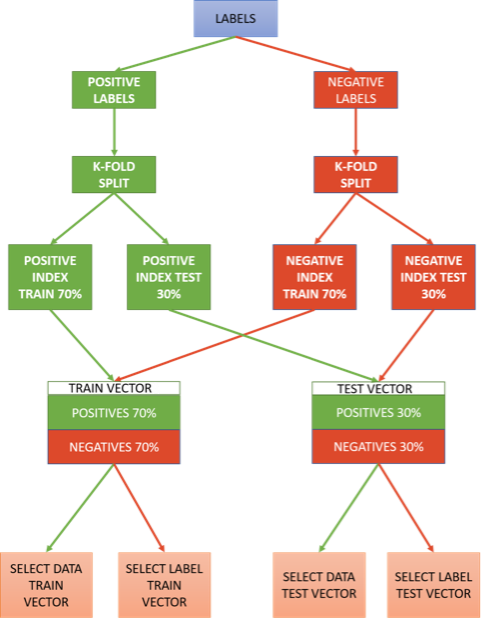

In [ ]:
# import KFold and random
from sklearn.model_selection import KFold
import random


# set the number of folds
num_folds=3

# set random seed for cross validation
CROSS_VAL_SEED = 42

# create the KFold object and create the splits for positive data
kf_posi = KFold(n_splits=num_folds)
kf_posi.get_n_splits(posi_id)
kf_posi = KFold(n_splits=num_folds, random_state=CROSS_VAL_SEED, shuffle=True)
posi_folds=list(kf_posi.split(posi_id))

# create the KFold object and create the splits for negative data
kf_neg = KFold(n_splits=num_folds)
kf_neg.get_n_splits(posi_id)
kf_neg = KFold(n_splits=num_folds, random_state=CROSS_VAL_SEED, shuffle=True)
neg_folds=list(kf_neg.split(neg_id))

# loop over the folds to create train and test data/label. 

for fold_idx, (train_index_posi, test_index_posi) in enumerate(posi_folds):

    print(f'Running fold {fold_idx+1}...')
    
    # Get the current fold for positive data
    fold_train_posi = np.array(posi_id)[train_index_posi]
    fold_test_posi = np.array(posi_id)[test_index_posi]
    
    # Get the current fold for negative data
    train_index_neg,test_index_neg=neg_folds[fold_idx]
    fold_train_neg=np.array(neg_id)[train_index_neg]
    fold_test_neg=np.array(neg_id)[test_index_neg]
    
    # ensure that we have balanced classes in both train and test
    assert len(fold_train_posi)==len(fold_train_neg)
    assert len(fold_test_posi)==len(fold_test_neg)
    # combine all train and test for the current fold
    fold_train=np.concatenate([fold_train_posi,fold_train_neg])
    fold_test=np.concatenate([fold_test_posi,fold_test_neg])
    
    # use the indexes in fold_train and fold_test to slice data and labels
    fold_train_data=data[fold_train]
    fold_test_data=data[fold_test]
    fold_train_label=labels[fold_train]
    fold_test_label=labels[fold_test]
    

Running fold 1...
Running fold 2...
Running fold 3...


Again, we can wrap the above into a function `create_kfold_validadtion()`.

In [ ]:
def create_kfold_validation(data,labels,num_folds):
    """
    Parameters
    ----------
    data: a numpy array of features
    labels: a numpy array of labels (1=positive, 0=negative)
    num_folds: the number of folds in cross validation

    Yields (works as a generator)
    ------
    fold_train_data: current fold of training data as numpy arrays
    fold_test_data: current fold of test data as numpy arrays
    fold_train_label: current fold of training labels as numpy arrays
    fold_test_label: current fold of test labels as numpy arrays
    """
    #produce the indices for the positive and the negative data
    posi_id=[i for i,label in enumerate(labels) if label==1]
    neg_id=[i for i,label in enumerate(labels) if label==0]

    # set random seed for cross validation
    cross_val_seed = 42

    # create the KFold object and create the splits for positive data
    kf_posi = KFold(n_splits=num_folds)
    kf_posi.get_n_splits(posi_id)
    kf_posi = KFold(n_splits=num_folds, random_state=CROSS_VAL_SEED, shuffle=True)
    posi_folds=list(kf_posi.split(posi_id))

    # create the KFold object and create the splits for negative data
    kf_neg = KFold(n_splits=num_folds)
    kf_neg.get_n_splits(posi_id)
    kf_neg = KFold(n_splits=num_folds, random_state=CROSS_VAL_SEED, shuffle=True)
    neg_folds=list(kf_neg.split(neg_id))

    # loop over the folds to create train and test data/label. 

    for fold_idx, (train_index_posi, test_index_posi) in enumerate(posi_folds):

        print(f'Running fold {fold_idx+1}...')

        # Get the current fold for positive data
        fold_train_posi = np.array(posi_id)[train_index_posi]
        fold_test_posi = np.array(posi_id)[test_index_posi]

        # Get the current fold for negative data
        train_index_neg,test_index_neg=neg_folds[fold_idx]
        fold_train_neg=np.array(neg_id)[train_index_neg]
        fold_test_neg=np.array(neg_id)[test_index_neg]

        # ensure that we have balanced classes in both train and test
        assert len(fold_train_posi)==len(fold_train_neg)
        assert len(fold_test_posi)==len(fold_test_neg)
        # combine all train and test for the current fold
        print ('combining positive and negative for train and test')
        fold_train=np.concatenate([fold_train_posi,fold_train_neg])
        fold_test=np.concatenate([fold_test_posi,fold_test_neg])
        
        
        # use the indexes in fold_train and fold_test to slice data and labels
        print ('slice training and test data')
        fold_train_data=data[fold_train]
        fold_test_data=data[fold_test]
        fold_train_label=labels[fold_train]
        fold_test_label=labels[fold_test]
        print ('yield')
        
        assert len(fold_train_data)==len(fold_train_label)
        assert len(fold_test_data)==len(fold_test_label)
        yield fold_train_data,fold_test_data,fold_train_label,fold_test_label

    

When we call `create_kfold_validation()`, we are initializing a generator. We can loop over the generator to produce `fold_train_data,fold_test_data,fold_train_label,fold_test_label`  for every fold

In [ ]:
for fold_train_data,fold_test_data,fold_train_label,fold_test_label in create_kfold_validation(np.array(data),labels,num_folds=3):
    print ('length of train data',len(fold_train_data))
    print ('length of test data',len(fold_test_data))

    

Running fold 1...
combining positive and negative for train and test
slice training and test data
yield
length of train data 1332
length of test data 668
Running fold 2...
combining positive and negative for train and test
slice training and test data
yield
length of train data 1334
length of test data 666
Running fold 3...
combining positive and negative for train and test
slice training and test data
yield
length of train data 1334
length of test data 666


## Naive Bayes Model and evaluation

Let's try fitting the features and labels from each validation fold into a naive bayes model using the `MultinomialNB` package in `sklearn`. `MultinomialNB` is a Naive Bayes classifier for multinomial models (i.e. for multiclass problems). It implements additive smoothing by default. For more details, please see [scikit-learn's multinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)

In [ ]:
!pip install sklearn
from sklearn.naive_bayes import MultinomialNB

for fold_train_data,fold_test_data,fold_train_label,fold_test_label in create_kfold_validation(data,labels,num_folds=3):
    # initialize a multinomial naive bayes model
    model = MultinomialNB()
    # fit the model with features and labels for the training data
    model.fit(fold_train_data,fold_train_label)
    #evaluate the fitted model on the test set
    predicted=model.predict(fold_test_data)

Running fold 1...
combining positive and negative for train and test
slice training and test data
yield
Running fold 2...
combining positive and negative for train and test
slice training and test data
yield
Running fold 3...
combining positive and negative for train and test
slice training and test data
yield


In each fold, `predicted` is an array of predictions in 1s and 0s. Let's compare it with the gold labels and calculate accuracy following:

<code>accruracy= number of correct examples/number of total examples</code>

**<h3>💻 Try it yourself!</h3>**

Please complete the function `get_accuracy()` below


In [ ]:
def get_accuracy(predicted,gold):
    """
    Parameters
    ----------
    predicted: a list or numpy array of predicted labels in the form of 1=positive, 0=negative
    gold: a list or numpy array of gold labels in the form of 1=positive, 0=negative

    Return
    ------
    accuracy score
    """

    


<hr>    <!-- please remember this! -->
<details>
  <summary>Click <b>here</b> to see the answer.</summary>
  <p><pre><code>
    def get_accuracy(predicted,gold):
        """
        Parameters
        ----------
        predicted: a list or numpy array of predicted labels in the form of 1=positive, 0=negative
        gold: a list or numpy array of gold labels in the form of 1=positive, 0=negative<br>
        Return
        ------
        accuracy score
        """
        correct=0
        for i in range(len(predicted)):
            if predicted[i]==gold[i]: #if the predicted result is the same with the gold label
                correct+=1
        acc=correct/len(predicted)
        return acc
</p></pre></code>
  

   

<!--   <p>\begin{equation*}P(Fire|Smoke) =  \frac{P(Fire)*P(Smoke|Fire)}{P(Smoke)} \end{equation*} </p>
<p>\begin{equation*}=\frac{0.01 * 0.9}{ 0.1} \end{equation*}</p>
<p>\begin{equation*}=0.09\end{equation*}</p> -->

</details> 



Let's create a function that calls the naive bayes model and performs evaluation 

In [ ]:
def train_evaluate(train_data,train_label,test_data,test_label):
    """
    Parameters
    ----------
    train_data: numpy array of train data (number of examples * number of features)
    train_label: numpy array of train labels in the form of [1,0,1...] where 1 = positive, 0 = negative
    test_data: numpy array of test data (number of examples * number of features)
    test_label: numpy array of test labels in the form of [1,0,1...] where 1 = positive, 0 = negative

    Return
    ------
    accuracy score on the test data
    """
    # initialize a multinomial naive bayes model
    model = MultinomialNB()
    # fit the model with features and labels for the training data
    model.fit(train_data,train_label)
    #evaluate the fitted model on the test set
    predicted=model.predict(test_data)
    #evaluation:
    acc=get_accuracy(predicted,test_label)


    print ('accuracy',acc)
    return acc

Now integrating `train_evaluate()` into cross validation, we will get accuracy per each fold. We then take the average and standard deviation of the accuracy scores across folds. 

In [ ]:
acc_list=[]
for fold_train_data,fold_test_data,fold_train_label,fold_test_label in create_kfold_validation(data,labels,num_folds=3):
    acc=train_evaluate(fold_train_data,fold_train_label,fold_test_data,fold_test_label)
    acc_list.append(acc)
    
# mean and standard deviation
print(f'Mean accuracy      : { np.mean(acc_list):.5f}')
print(f'Standard deviation : { np.std(acc_list):.5f}')

Running fold 1...
combining positive and negative for train and test
slice training and test data
yield
accuracy 0.8353293413173652
Running fold 2...
combining positive and negative for train and test
slice training and test data
yield
accuracy 0.8318318318318318
Running fold 3...
combining positive and negative for train and test
slice training and test data
yield
accuracy 0.8288288288288288
Mean accuracy      : 0.83200
Standard deviation : 0.00266


If everything is correct, you should get:

    Mean accuracy      : 0.83200
    Standard deviation : 0.00266

# Recap: The whole pipeline to train on unigram presence features

In [ ]:
# 1. Extract unigrams from all documents
from os import listdir 
# unigrams for all the negative files
unigrams_neg=process_docs_unigrams('./data/neg')
# unigrams for all the positive files
unigrams_posi=process_docs_unigrams('./data/pos')
# all unigrams
unigrams_all=unigrams_posi+unigrams_neg

# 2. Turn text to feature vectors
# collect all unique unigram as all features
unigram_vocab=collect_vocab(unigrams_all)
# map unigram features to vector position indexes
unigram2index,index2unigram=create_vocab_feature_mappings(unigram_vocab)
# Convert unigrams to feature vectors for all documents
features_unigram_presence=create_feature_presence_all(unigrams_all,unigram2index)

# 3. Encode labels
labels=len(unigrams_posi)*[1]+len(unigrams_neg)*[0]
labels=np.array(labels)

# 4. Evaluation with 3-fold cross validation
data=features_unigram_presence
acc_list=[]
for fold_train_data,fold_test_data,fold_train_label,fold_test_label in create_kfold_validation(data,labels,num_folds=3):
    acc=train_evaluate(fold_train_data,fold_train_label,fold_test_data,fold_test_label)
    acc_list.append(acc)
    
# mean and standard deviation
print(f'Mean accuracy      : { np.mean(acc_list):.5f}')
print(f'Standard deviation : { np.std(acc_list):.5f}')


./data/neg
./data/pos
Running fold 1...
combining positive and negative for train and test
slice training and test data
yield
accuracy 0.8353293413173652
Running fold 2...
combining positive and negative for train and test
slice training and test data
yield
accuracy 0.8318318318318318
Running fold 3...
combining positive and negative for train and test
slice training and test data
yield
accuracy 0.8288288288288288
Mean accuracy      : 0.83200
Standard deviation : 0.00266


# Other features

## Bigrams

Based on `clean_doc_unigrams()` that turns a document into a unigram dictionary, we can create a function `clean_doc_bigrams()` to extract bigram dictionary. (You can refresh yourself of how to create a bigram counter dictionary in module 1.4. )

In [ ]:
# turn a doc into clean tokens
def clean_doc_bigrams(doc):
    """
    Parameters
    ----------
    doc: string of the document text

    Return
    ------
    a counter dictionary with bigram as key and count as value
    """
    # split into tokens by white space
    tokens = doc.split()
  
    # extract bigrams
    bigram_dict=Counter() #initialize a bigram dictionary to be updated
    tokens=['<start>']+tokens+['<end>'] # add <start> and <end> token
    for i in range(len(tokens)): #loop over all the indices of the token list
        if i<len(tokens)-1: #if it's not the end of the token list
            bigram_current=(tokens[i],tokens[i+1])
            bigram_dict[bigram_current]+=1
    return bigram_dict

Now we can replace the `clean_doc_unigrams()` line with `clean_doc_bigrams()` in `process_docs_unigrams()`, we will rename the function as `process_docs_bigrams()` that counts all the bigrams in the documents. 

In [ ]:
def process_docs_bigrams(directory):
    """
    Parameters
    ----------
    directory: a directory containing positive/negative samples from the Thumbs
    Up! dataset.
    overall_bigrams_counter: 

    Return
    ------
    a list of bigram counters each representing a document
    """
    # walk through all files in the folder
    tokens_all=[]
    print (directory)
    files=sorted(listdir(directory))
    for filename in files:
        # skip files that do not have the right extension
        if not filename.endswith(".txt"):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load document
        text=load_doc(path)
        # clean documents
        tokens_dict_current = clean_doc_bigrams(text)
        tokens_all.append(tokens_dict_current)
    return tokens_all
bigrams_neg=process_docs_bigrams('./data/neg')
bigrams_posi=process_docs_bigrams('./data/pos')
bigrams_all=bigrams_posi+bigrams_neg

./data/neg
./data/pos


As te same with unigram features, we then extract bigram feature vocabulary by calling `collect_vocab()`




In [ ]:
bigram_vocab=collect_vocab(bigrams_all)


Try printing the length of `bigram_vocab`, how large is it?





In [ ]:
print (len(bigram_vocab))

468412


Think about what will happen if we turn documents into feature vectors with such large feature size. We will have a very long vector for each document, and the final matrix will be extremely large. To trim the vocabulary a little bit, we impose min_count argument to be 2, thus discarding bigrams that occur fewer than 2 times. 

In [ ]:
bigram_vocab=collect_vocab(bigrams_all,min_count=2)#As the number of total bigrams is too large, we discard bigrams that occur few than 2 times
print ('bigram feature size', len(bigram_vocab))
bigram2index,index2bigram=create_vocab_feature_mappings(bigram_vocab)
features_bigram_presence=create_feature_presence_all(bigrams_all,bigram2index)


bigram feature size 75636


The labels are the same for `features_unigram_presence`. We can then directly train Naive Bayes model with these bigram presence features. You can compare the bigram results with unigram results. Which is better?

In [ ]:
data=features_bigram_presence
acc_list=[]
for fold_train_data,fold_test_data,fold_train_label,fold_test_label in create_kfold_validation(data,labels,num_folds=3):
    acc=train_evaluate(fold_train_data,fold_train_label,fold_test_data,fold_test_label)
    acc_list.append(acc)
    
# mean and standard deviation
print(f'Mean accuracy      : { np.mean(acc_list):.5f}')
print(f'Standard deviation : { np.std(acc_list):.5f}')

Running fold 1...
combining positive and negative for train and test
slice training and test data
yield
accuracy 0.842814371257485
Running fold 2...
combining positive and negative for train and test
slice training and test data
yield
accuracy 0.8363363363363363
Running fold 3...
combining positive and negative for train and test
slice training and test data
yield
accuracy 0.8453453453453453
Mean accuracy      : 0.84150
Standard deviation : 0.00379


If everything goes right, you should see the following:

Mean accuracy      : 0.84150<br>
Standard deviation : 0.00379

# ✍️ Final *Assessment*

Part 1: So far we have trained a model and evaluated on the bigram and unigram presence features, can you modify the pipeline to build a model on bigram frequency features (min_count=2) with three fold cross validation? Please report mean and accuracy of the results with CROSS_VAL_SEED=42. How do the results compare with bigram presence features? 



Part 2: Do we need all bigrams for a good prediction? Based on your code in Part 1, try changing min_count to 5,10,50,100,500; and report the mean and standard deviation accordingly. Suppose that we need at least 75% performance, what is the smallest total bigram vocab/highest min_count (selected among [5,10,50,100,500]) we can set?






# Survey

Please complete the [post-module survey](https://docs.google.com/forms/d/e/1FAIpQLSeLX1N344kBn8q9PTgg455lrzvVzzI5IW9itF4cT_WqeQKaFQ/viewform) when you are finished. Thank you!

# Additional resources

- Naive Bayes chapter from [Manning, Raghavan and Schütze's Introduction to Information Retrieval](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html)
-  `scikit-learn`'s [implementation of Naive Bayes](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/naive_bayes.py#L669)
- Pang, Lee, Vaithyanathan, 2002, Thumbs up? Sentiment Classification using Machine Learning Techniques [pdf](https://www.aclweb.org/anthology/W02-1011.pdf)